In [1]:
import esmvalcore.experimental as esmvaltool
import esmvalcore.preprocessor._regrid_esmpy as _regrid_esmpy
import esmvalcore.preprocessor._regrid as _regrid

import xarray as xr
import xesmf as xe
import numpy as np

import iris

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt

/gxfs_home/geomar/smomw522/miniconda3/envs/test_env/lib/python3.10/site-packages/esmvalcore/experimental/_warnings.py:13: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498
ERROR 1: PROJ: proj_create_from_database: Open of /gxfs_home/geomar/smomw522/miniconda3/envs/test_env/share/proj failed


# Run the recipe to have auto download

This is just an example worth about 60MB. In this model the "northpole" is moved to be over greenland. But tripolar models would present similarly in coord structure.

In [2]:
%cat recipe_download.yml

documentation:
  description: dummy
  title: dummy
  authors:
    - righi_mattia

datasets:
  - {dataset: MPI-ESM1-2-LR, project: CMIP6, exp: 1pctCO2, ensemble: r1i1p1f1, grid: gn, timerange: "1850/1870"}

diagnostics:
  download:
    description: dummy diagnostic to trigger autodownload
    variables:
      fgco2:
        mip: Omon
    scripts: null


In [3]:
recipe = esmvaltool.Recipe("recipe_download.yml")
output = recipe.run()

 Long name for fgco2 changed from Surface Downward Flux of Total CO2 to Surface Downward Mass Flux of Carbon as CO2 [kgC m-2 s-1]
 fgco2: attribute positive not present
loaded from file /gxfs_home/geomar/smomw522/climate_data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/1pctCO2/r1i1p1f1/Omon/fgco2/gn/v20190710/fgco2_Omon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_185001-186912.nc
 Long name for fgco2 changed from Surface Downward Flux of Total CO2 to Surface Downward Mass Flux of Carbon as CO2 [kgC m-2 s-1]
 fgco2: attribute positive not present
loaded from file /gxfs_home/geomar/smomw522/climate_data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/1pctCO2/r1i1p1f1/Omon/fgco2/gn/v20190710/fgco2_Omon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_187001-188912.nc
 fgco2: attribute positive not present
loaded from file 


In [4]:
taskoutput = output["download/fgco2"]
datafile = taskoutput.data_files[0]

## Load example data as iris.Cube and xarray.DataSet

In [5]:
cube = datafile.load_iris().concatenate_cube()
xrds = datafile.load_xarray()

Define target Cube/Dataset with regular rectilinear grids

In [6]:
cube_target = _regrid._global_stock_cube("1x1") # LONxLAT

In [7]:
xrds_target = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-90, 90, 1)),
        "lon": (["lon"], np.arange(0, 360, 1)),
    }
)

In [8]:
cube_target.shape

(180, 360)

In [9]:
xrds_target.dims

Frozen({'lat': 180, 'lon': 360})

## 0. First attempt with iris builtin regridding and the PointInCell scheme is not working.

Why does it require a CRS?

In [10]:
cube.regrid(cube_target, scheme=iris.analysis.PointInCell())

ValueError: The source X and Y coordinates must have a defined coordinate system.

# 0.1 What if we assume WGS84 like in iris.cartography.project?

In [11]:
wgs84 = iris.coord_systems.GeogCS(semi_major_axis=6378137.0, inverse_flattening=298.257223563)

In [12]:
cube.coord_system = wgs84
cube.coord(axis="x").coord_system = wgs84
cube.coord(axis="y").coord_system = wgs84

cube_target.coord_system = wgs84
cube_target.coord(axis="x").coord_system = wgs84
cube_target.coord(axis="y").coord_system = wgs84

In [13]:
cube_out = cube.regrid(cube_target, scheme=iris.analysis.PointInCell())

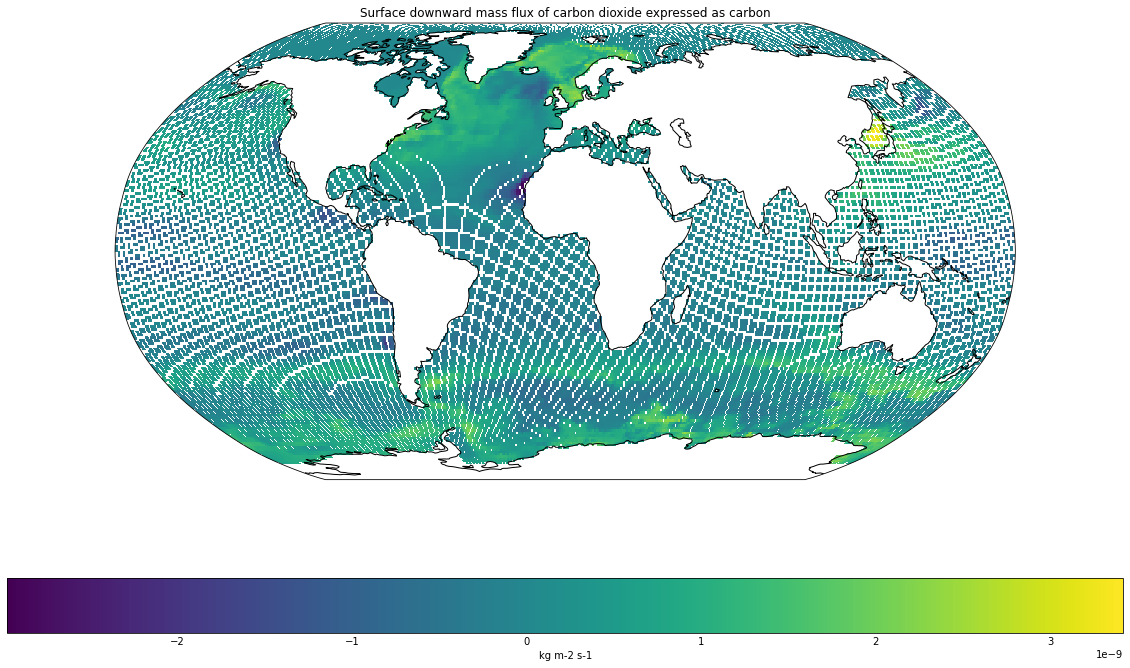

In [14]:
plt.figure(figsize=(20, 12))
ax = plt.axes(projection=ccrs.Robinson())
qplt.pcolormesh(cube_out[0])
plt.gca().coastlines()

No ;) but I guess it makes sense as there are not enough source points to the in the cell.

# 1. Builtin esmvalcore function that is also used by `regrid` preprocessor

In [15]:
cube_out = _regrid_esmpy.regrid(cube, cube_target, "linear")

In [16]:
iris.save(cube_out, "iris.nc")

### It's slow!

In [17]:
%timeit _regrid_esmpy.regrid(cube, cube_target, "linear")

16.9 s ± 50.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


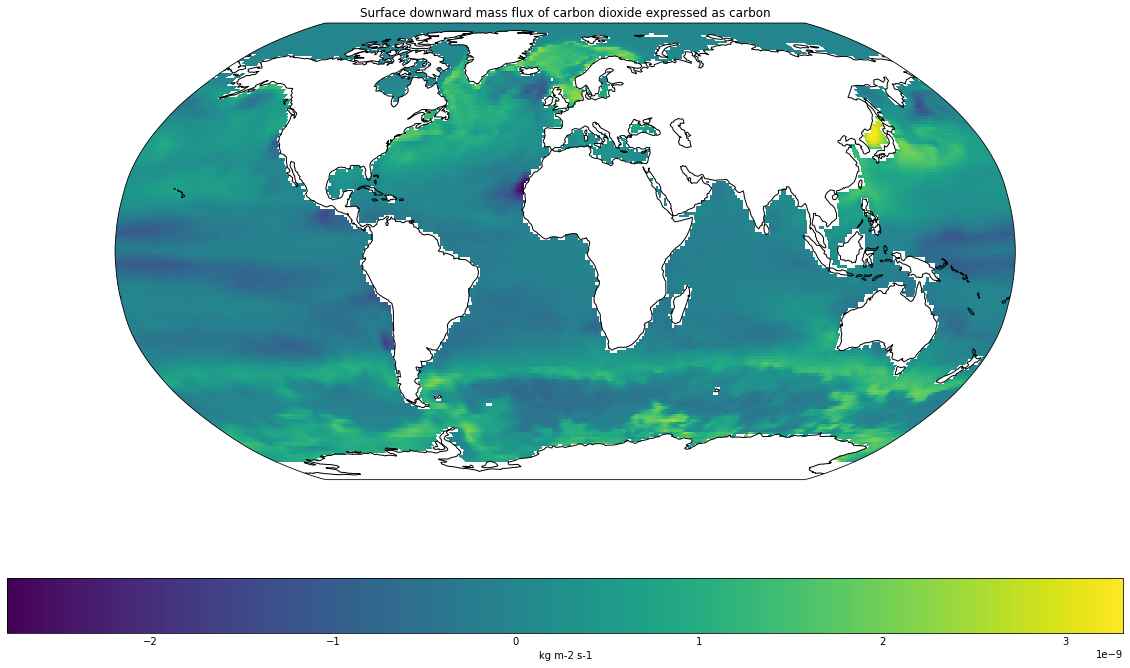

In [18]:
plt.figure(figsize=(20, 12))
ax = plt.axes(projection=ccrs.Robinson())
qplt.pcolormesh(cube_out[0])
plt.gca().coastlines()

# 2. xesmf regridding 

In [19]:
regridder = xe.Regridder(xrds, xrds_target, "bilinear", filename="weights", reuse_weights=False)

In [20]:
xrds_out = regridder(xrds)

/gxfs_home/geomar/smomw522/miniconda3/envs/test_env/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
/gxfs_home/geomar/smomw522/miniconda3/envs/test_env/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.


In [21]:
xrds_out.to_netcdf("xr.nc")

### 60x times faster on my laptop!
I believe the reason is that xesmf only computes the weights using ESMPy, but then applies them to the data with scipy sparse matrix multiplication.

In [22]:
%%timeit
regridder = xe.Regridder(xrds, xrds_target, "bilinear", filename="weights", reuse_weights=True)
xrds_out = regridder(xrds)

/gxfs_home/geomar/smomw522/miniconda3/envs/test_env/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.


418 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Even without reusing the weights (which is the expensive part in xesmf) its still 10x faster. This will scale faster with more data.

In [23]:
%%timeit
regridder = xe.Regridder(xrds, xrds_target, "bilinear", filename="weights", reuse_weights=False)
xrds_out = regridder(xrds)

2.53 s ± 242 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


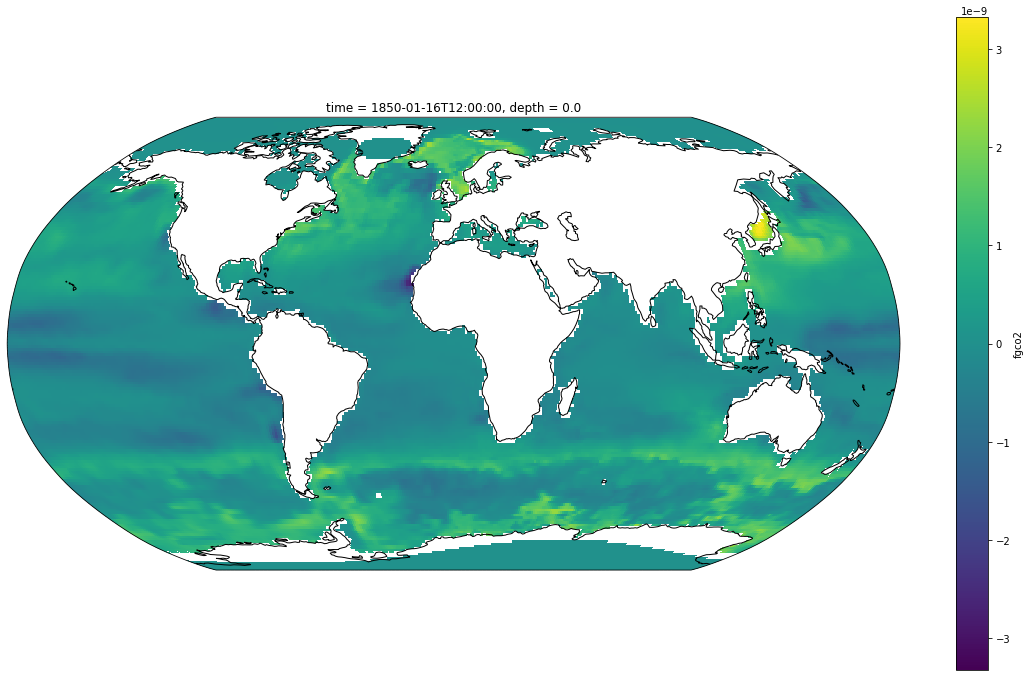

In [24]:
plt.figure(figsize=(20, 12))
ax = plt.axes(projection=ccrs.Robinson())
xrds_out.fgco2[0].plot.pcolormesh(transform=ccrs.PlateCarree(), cmap="viridis")
ax.coastlines()

### Masking on Antarctica and Greenland (near poles) is lost.

# 3. Nearest neighbour in iris.analysis.cartography.project
Fine for plotting but not usable for computing statistics!

In [25]:
import iris.analysis.cartography

target_proj = ccrs.PlateCarree()
projected, extent = iris.analysis.cartography.project(cube, target_proj,
                                                         nx=360, ny=180)

#plt.gca().coastlines()

/gxfs_home/geomar/smomw522/miniconda3/envs/test_env/lib/python3.10/site-packages/iris/analysis/cartography.py:821: UserWarning: Discarding coordinates that share dimensions with latitude and longitude: ['cell index along first dimension', 'cell index along second dimension']


/gxfs_home/geomar/smomw522/miniconda3/envs/test_env/lib/python3.10/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'projection_x_coordinate' is not bounded, guessing contiguous bounds.
/gxfs_home/geomar/smomw522/miniconda3/envs/test_env/lib/python3.10/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'projection_y_coordinate' is not bounded, guessing contiguous bounds.


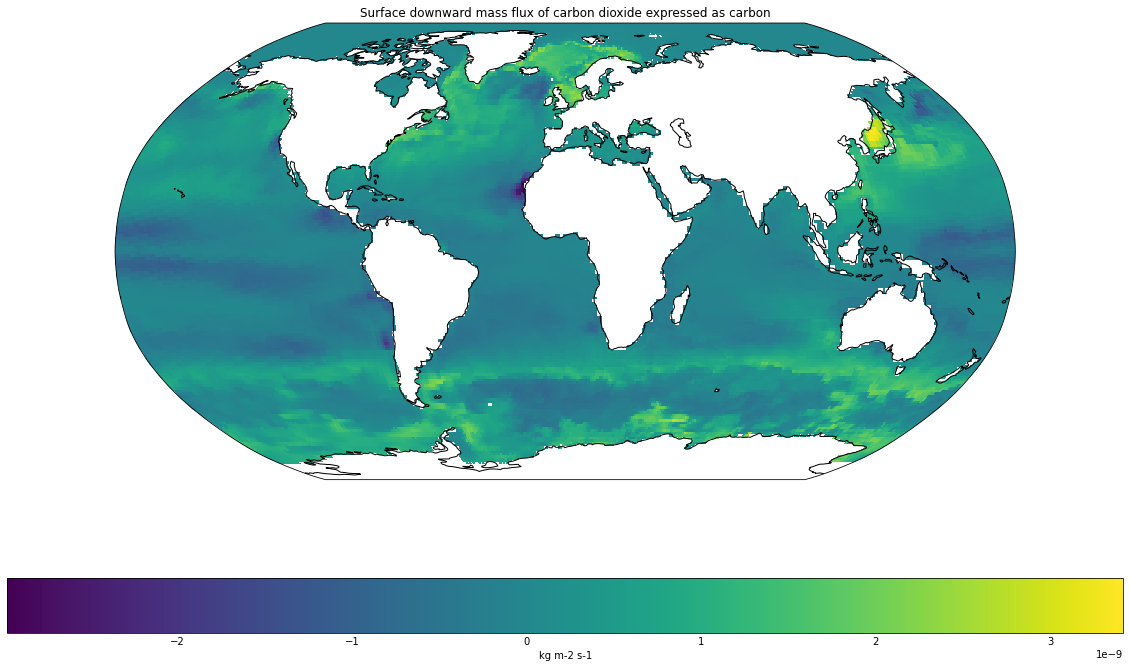

In [26]:
plt.figure(figsize=(20, 12))
plt.axes(projection=ccrs.Robinson(0))
qplt.pcolormesh(projected[0])
plt.gca().coastlines()

# Playing with the data (stop reading ;):

In [ ]:
projected.coords()

In [ ]:
regridder.weights.data

In [ ]:
xrds['fgco2'].values.flags

In [ ]:
cube.data.flags

In [ ]:
iris.analysis.maths.apply_ufunc(xe.Regridder.regrid_array, cube, regridder.weights.data)

In [ ]:
xe.Regridder.regrid_array

In [ ]:
regridder.regrid_array(cube.data, regridder.weights.data)

In [ ]:
cube.data.fill_value

In [ ]:
xcoord = cube.coord(axis="x")

In [ ]:
cube.coord_dims(xcoord)

In [ ]:
cube_out.coord(axis="x").shape

In [ ]:
xrds.nbytes/1024/1024